In [1]:
%load_ext autoreload

In [2]:
import distributed as dd
import numpy as np
import dask.array as da
import dask

from libertem.api import Context
from libertem.executor.delayed import DelayedJobExecutor
from libertem.udf.base import UDF
from libertem.udf.base import get_resources_for_backends

In [3]:
ctx = Context.make_with("dask-make-default")
# ctx = Context()
del_ctx = Context(executor=DelayedJobExecutor())

distributed.utils - INFO - Reload module tmpj1y9k7pb from .py file
distributed.utils - INFO - Reload module tmp37sso2u8 from .py file
distributed.preloading - INFO - Import preload module: /tmp/tmpj1y9k7pb.py
distributed.preloading - INFO - Import preload module: /tmp/tmp37sso2u8.py
distributed.utils - INFO - Reload module tmp2t7t45wk from .py file
distributed.utils - INFO - Reload module tmpsuzbv3j0 from .py file
distributed.preloading - INFO - Import preload module: /tmp/tmp2t7t45wk.py
distributed.preloading - INFO - Import preload module: /tmp/tmpsuzbv3j0.py
distributed.utils - INFO - Reload module tmpc3vhxnhn from .py file
distributed.utils - INFO - Reload module tmplez6rikz from .py file
distributed.preloading - INFO - Import preload module: /tmp/tmpc3vhxnhn.py
distributed.preloading - INFO - Import preload module: /tmp/tmplez6rikz.py
distributed.utils - INFO - Reload module tmp7xum667j from .py file
distributed.utils - INFO - Reload module tmpza6ul17n from .py file
distributed.pr

In [4]:
class MySumUDF(UDF):
    def get_result_buffers(self):
        return {
            'intensity': self.buffer(kind='sig', dtype=self.meta.input_dtype)
        }

    def process_tile(self, tile):
        self.results.intensity[:] += np.sum(tile, axis=0)

    def merge(self, dest, src):
        dest.intensity[:] += src.intensity

In [5]:
class MySumSigUDF(UDF):
    def get_result_buffers(self):
        return {
            'intensity': self.buffer(
                kind="nav", dtype=self.meta.input_dtype
            ),
        }

    def process_tile(self, tile):
        self.results.intensity[:] += np.sum(tile, axis=tuple(range(1, len(tile.shape))))

In [6]:
ds = ctx.load('EMPAD', '/cachedata/reference/EMPAD/BiFeO3/acquisition_12.xml')
ds.set_num_cores(2)

In [7]:
ds = ctx.load('memory', data=np.ones((32, 32, 32, 32)), num_partitions=4)

In [8]:
res_sum = del_ctx.run_udf(dataset=ds, udf=MySumUDF())

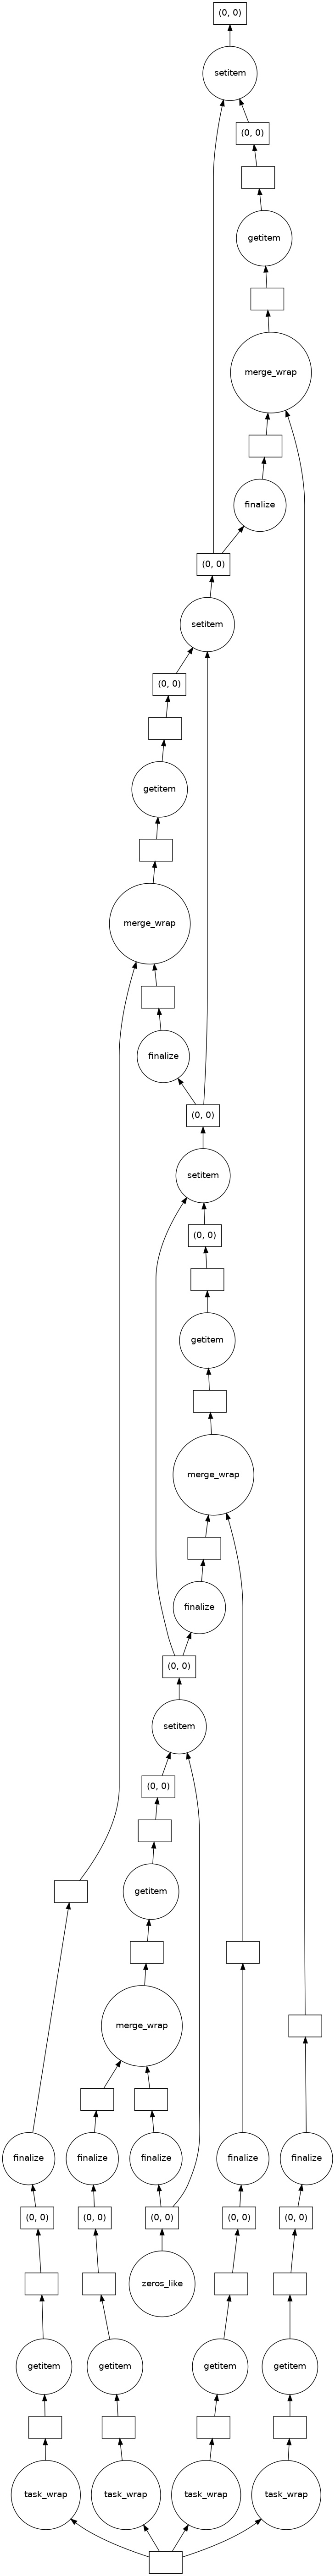

In [9]:
res_sum['intensity'].data.visualize()

In [10]:
%%timeit
res_sum = ctx.run_udf(dataset=ds, udf=MySumUDF())

/home/weber/miniconda3/envs/ptycho38/lib/python3.8/site-packages/distributed/worker.py:3877: UserWarning: Large object of size 8.00 MiB detected in task graph: 
  (<UDFTask [<class '__main__.MySumUDF'>]>, 'UDFPara ... 86adcb6560', 0)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


110 ms ± 4.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
res_sumsig = ctx.run_udf(dataset=ds, udf=MySumSigUDF())

103 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


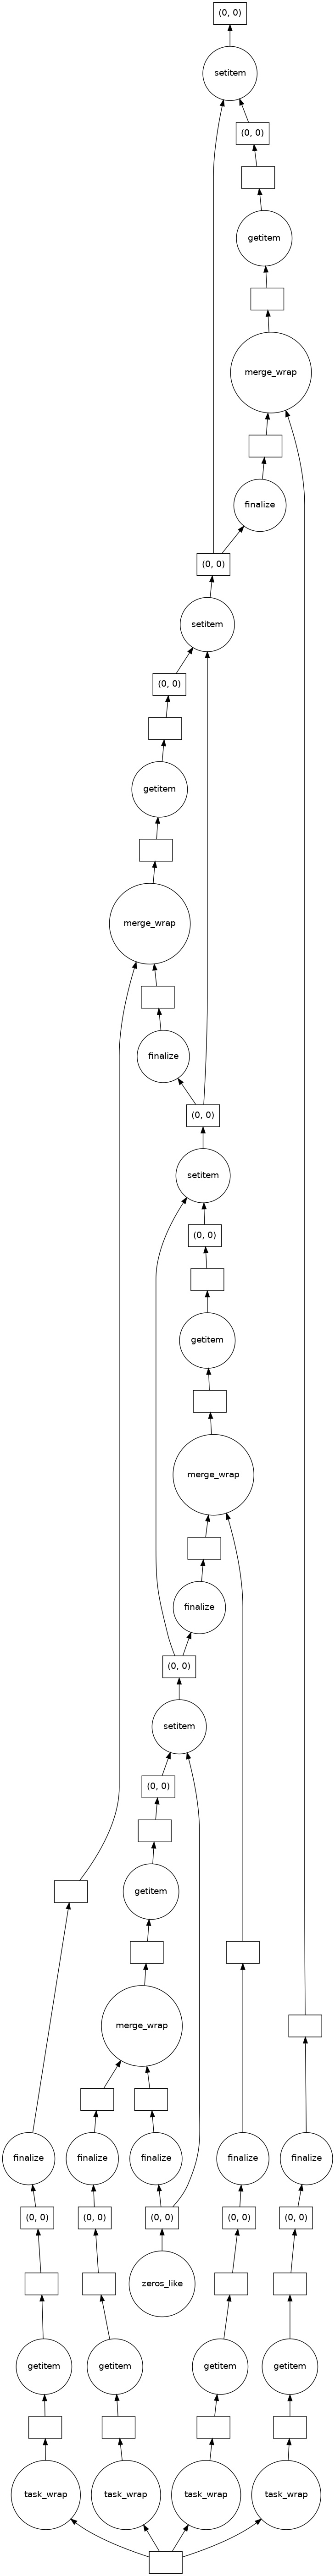

In [12]:
udf = MySumUDF()
resources = DelayedJobExecutor.get_resources_from_udfs(udf)
del_res_sum = del_ctx.run_udf(dataset=ds, udf=udf)
del_res_sum['intensity'].raw_data.visualize()

In [13]:
class MySumMergeUDF(MySumUDF):
    def merge_all(self, ordered_results):
        intensity = np.stack([b.intensity for b in ordered_results.values()]).sum(axis=0)
        return {'intensity': intensity}

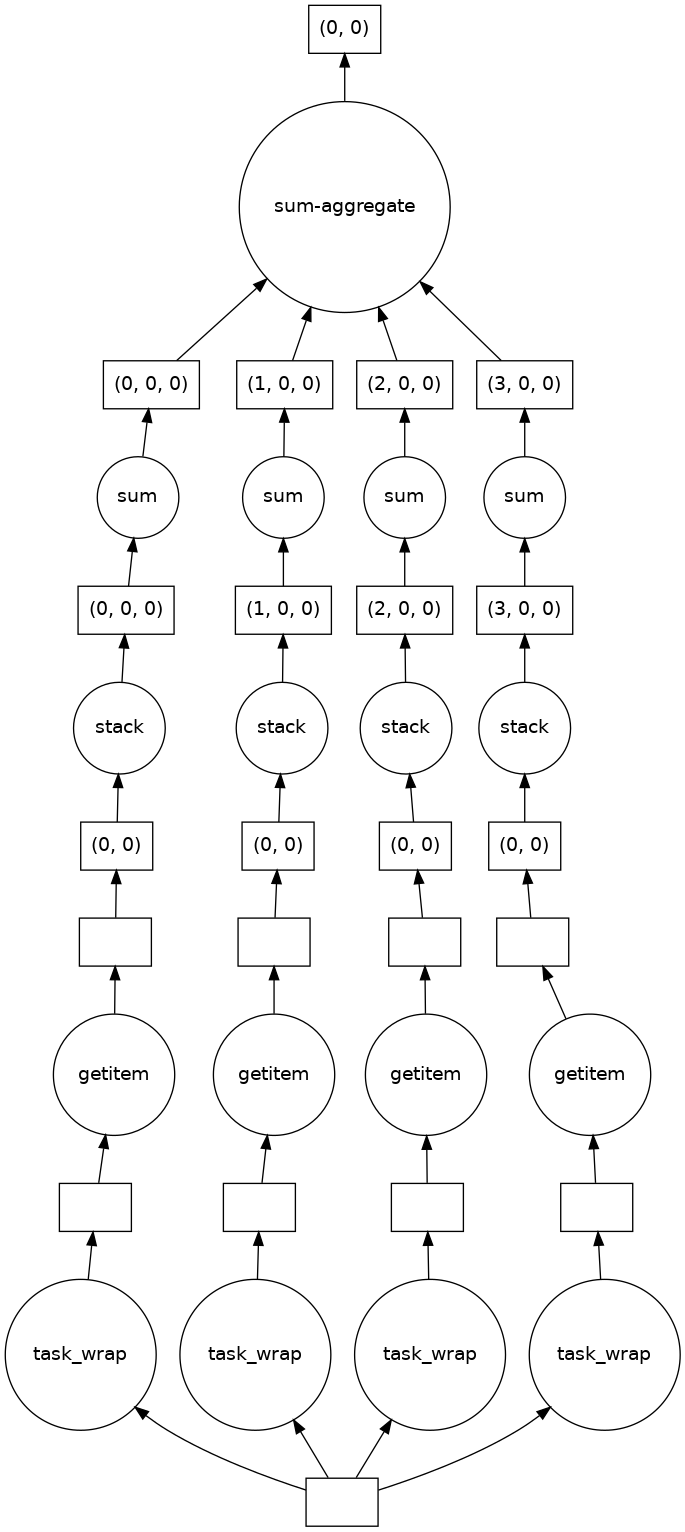

In [14]:
udf = MySumMergeUDF()
resources = DelayedJobExecutor.get_resources_from_udfs(udf)
del_res_sum = del_ctx.run_udf(dataset=ds, udf=udf)
del_res_sum['intensity'].data.visualize()

In [15]:
%%timeit
udf = MySumSigUDF()
del_res_sumsig = del_ctx.run_udf(dataset=ds, udf=udf)
del_res_sumsig['intensity'].raw_data.compute()

The slowest run took 7.10 times longer than the fastest. This could mean that an intermediate result is being cached.
315 ms ± 161 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


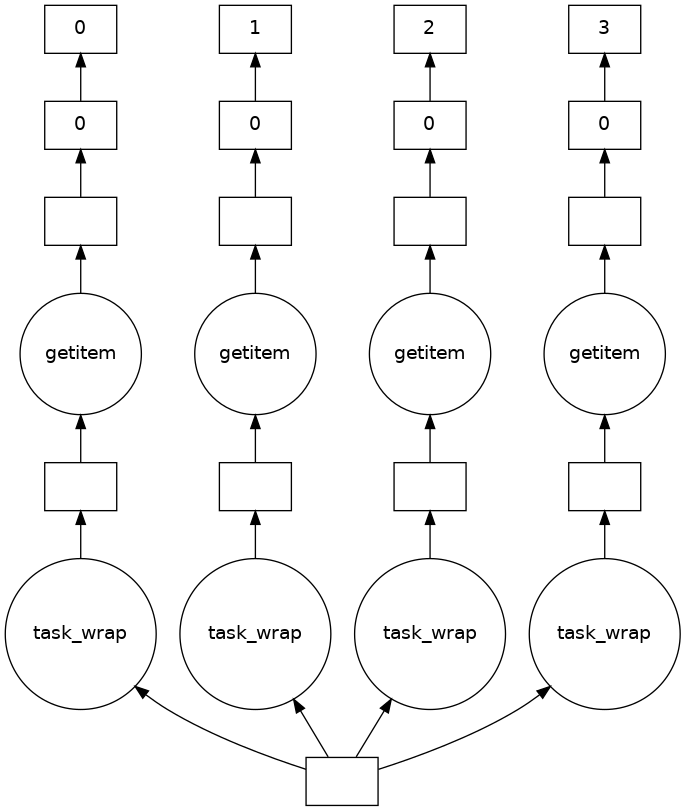

In [16]:
udf = MySumSigUDF()
del_res_sumsig = del_ctx.run_udf(dataset=ds, udf=udf)
del_res_sumsig['intensity'].raw_data.visualize()


In [19]:
class MySumSigMergeUDF(MySumSigUDF):
    def merge_all(self, ordered_results):
        intensity = np.concatenate([b.intensity for b in ordered_results.values()])
        return {'intensity': intensity}

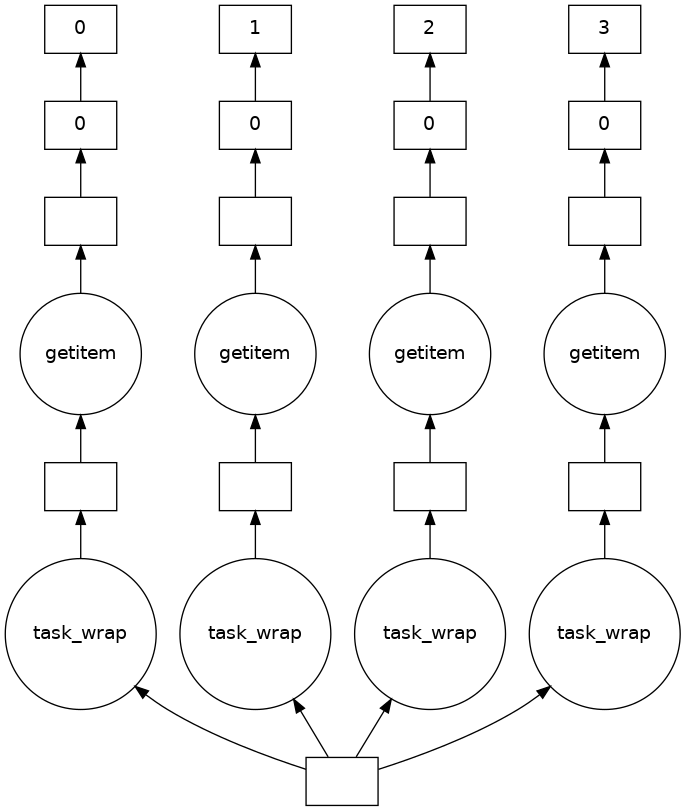

In [20]:
udf = MySumSigMergeUDF()
del_res_sumsig = del_ctx.run_udf(dataset=ds, udf=udf)
del_res_sumsig['intensity'].raw_data.visualize()

In [21]:
%%timeit
udf = MySumSigMergeUDF()
del_res_sumsig = del_ctx.run_udf(dataset=ds, udf=udf)
del_res_sumsig['intensity'].raw_data.compute()

The slowest run took 6.70 times longer than the fastest. This could mean that an intermediate result is being cached.
319 ms ± 137 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
udf = MySumSigMergeUDF()
resources = DelayedJobExecutor.get_resources_from_udfs(udf)
del_res_sumsig = del_ctx.run_udf(dataset=ds, udf=udf)

In [23]:
udf = MySumSigUDF()
resources = DelayedJobExecutor.get_resources_from_udfs(udf)
del_res_sumsig_merge = del_ctx.run_udf(dataset=ds, udf=udf)

In [24]:
dask.compute(del_res_sumsig, del_res_sumsig_merge)

({'intensity': <DaskBufferWrapper kind=nav extra_shape=() backing=dask.array<concatenate, shape=(1024,), dtype=float64, chunksize=(256,), chunktype=numpy.ndarray>>},
 {'intensity': <DaskBufferWrapper kind=nav extra_shape=() backing=dask.array<concatenate, shape=(1024,), dtype=float64, chunksize=(256,), chunktype=numpy.ndarray>>})